# Corpus selection
We want to select a corpus for annotation that focuses on the weak points of our heuristics:
- complex and varied META forms that may not fit into our current patterns
- many different span types in each annotation, sourced from multiple entities
- lots of named entities in running text that can't be easily identified by a simple regex
- long annotations where a misidentification early on could lead to many errors

We can select for this by running our current heuristics on the whole corpus and pulling out documents that:
- have many (?) spans identified as possibly containing an entity
- have a length at least two standard deviations above the mean
- contain at least one identified span of each non-entity type (META, GRAF, SEM, PHON)

Found 1583 annotations more than 2 and less than 10 std deviations from the mean.


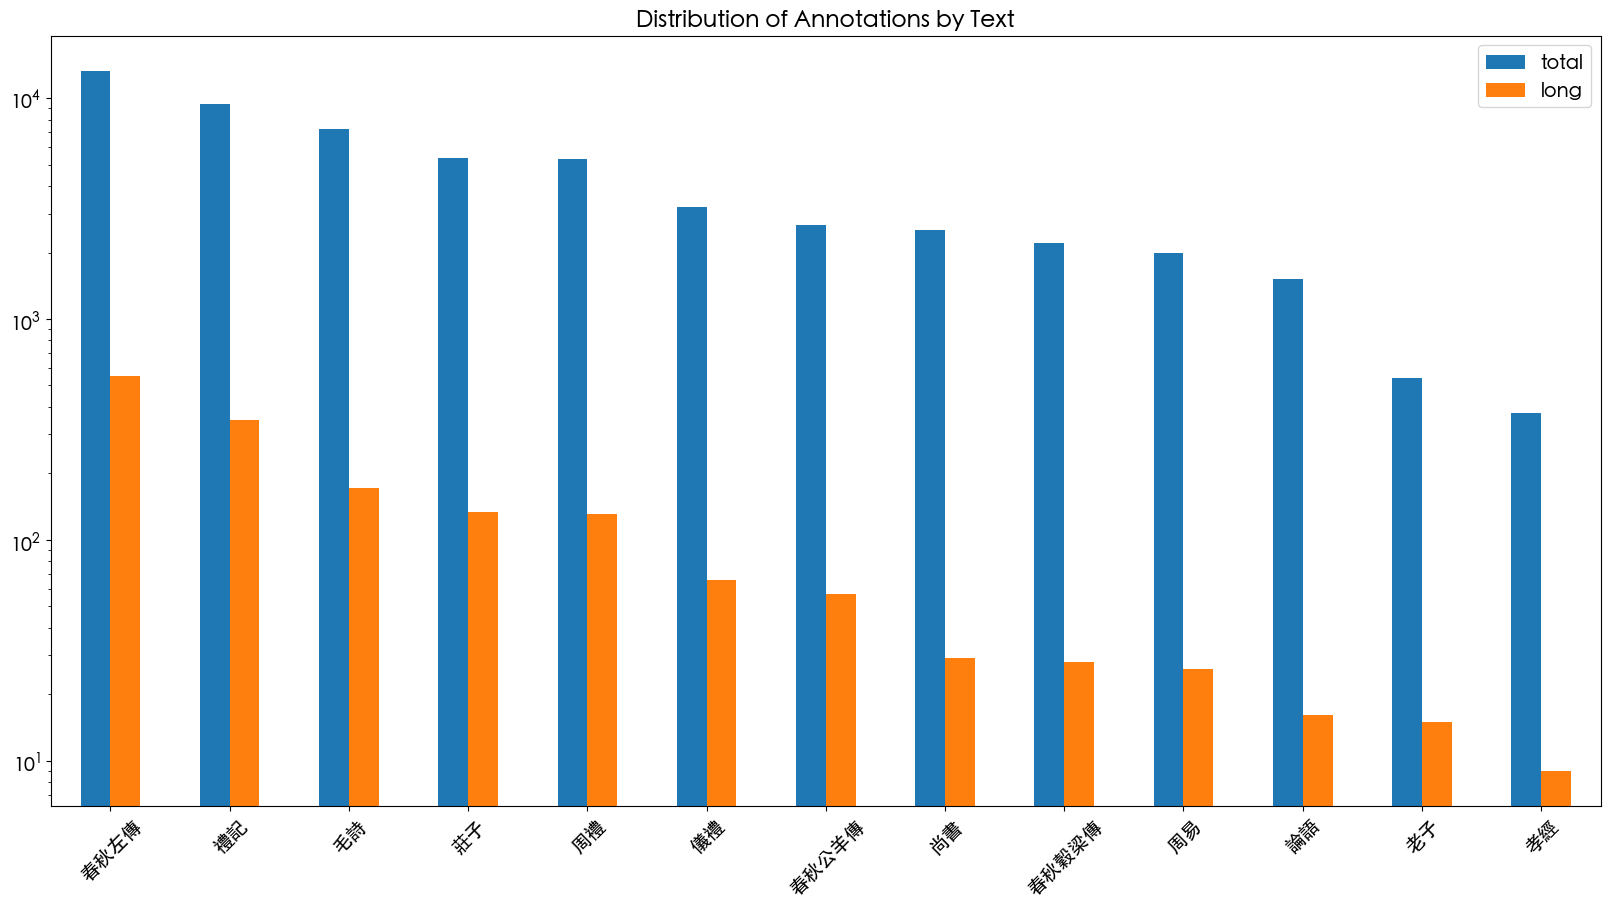

In [51]:
# import dependencies
import spacy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scripts.recipes.spancat import doc_spans_jdsw, span_rels_jdsw, SPAN_LABELS

# set the default font for everything so chinese characters display correctly
matplotlib.rcParams['font.family'] = "Heiti TC"
matplotlib.rcParams.update({'font.size': 14})

# load the data
df = pd.read_csv("../assets/annotations.csv")

# calculate the length of the annotation in std deviations from the mean
df["length"] = df["annotation"].apply(lambda x: len(x))
length_std = df["length"].std()
length_mean = df["length"].mean()
df["length_std"] = df["length"].apply(lambda x: (x - length_mean) / length_std)

# limit to annotations more than 2 std and less than 10 deviations longer than the mean
limited_df = df[(df["length_std"] > 2) & (df["length_std"] < 10)]
print(f"Found {len(limited_df)} annotations more than 2 and less than 10 std deviations from the mean.")

# plot the distribution of texts the annotations are from vs. the overall distribution
total_counts = df["title"].value_counts().values
long_counts = limited_df["title"].value_counts().values
index = df["title"].value_counts().keys()
cmp_df = pd.DataFrame({"total": total_counts, "long": long_counts}, index=index)
cmp_df.plot.bar(figsize=(20, 10), rot=45, title="Distribution of Annotations by Text", logy=True)
df = limited_df



In [52]:
# apply our span heuristics
df = limited_df
nlp = spacy.blank("zh")
df["spans"] = df["annotation"].apply(lambda x: doc_spans_jdsw(nlp.make_doc(x)))

In [53]:
# calculate the number of possible entities in each annotation
df["ent_count"] = df["spans"].apply(lambda x: len([span for span in x if span._.possible_entity]))
avg_ents = df["ent_count"].mean()
print(f"Found an average of {avg_ents} possible entities per annotation.")

Found an average of 3.2021478205938094 possible entities per annotation.


In [54]:
# calculate the number of unique span types in each annotation
df["span_types"] = df["spans"].apply(lambda x: len(set([span.label_ for span in x if span.label_ in SPAN_LABELS])))
avg_unique_spans = df["span_types"].mean()
print(f"Found an average of {avg_unique_spans} unique non-entity span types per annotation.")

Found an average of 3.2356285533796587 unique non-entity span types per annotation.


In [59]:
# limit to more than average possible entities and unique span types
df = df[(df["ent_count"] >= avg_ents) & (df["span_types"] >= avg_unique_spans)]
print(f"Found {len(df)} annotations with more than average possible entities and unique span types.")

# save the annotations to a JSONL file for use with spacy
import jsonlines
with jsonlines.open("../corpus/annotations-small.jsonl", "w") as writer:
    for row in df.to_dict(orient="records"):
        writer.write({
            "text": row["annotation"],
            "meta": {
                "source": row["title"],
                "headword": row["headword"],
                "juan": str(row["juan_title"]),
            }
        })


Found 391 annotations with more than average possible entities and unique span types.
